# Tarefa 01

- Leia os enunciados com atenção
- Saiba que pode haver mais de uma resposta correta
- Insira novas células de código sempre que achar necessário
- Em caso de dúvidas, procure os monitores
- Divirta-se :)

#### 1. Baixando dados de ativos
    1. Baixe os dados de três ativos da sua escolha do Yahoo Finance, correspondente a um período de pelo menos 2 anos até a data mais recente.
    2. Salve esses dados para que você possa utilizá-los na próxima tarefa.

In [1]:
import os
import sys
import subprocess
import importlib
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display

In [2]:
# (1) Instala/Importa e baixa dados de 3 ativos do Yahoo Finance + salva em arquivos

# Garantir yfinance instalado
if importlib.util.find_spec("yfinance") is None:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "yfinance"])

import yfinance as yf

# >>> Ativos
tickers = ["PETR4.SA", "VALE3.SA", "ITUB4.SA"]

# Período: pelo menos 2 anos até a data mais recente
fim = pd.Timestamp.today().normalize()
inicio = fim - pd.DateOffset(years=2)

# Pasta para salvar
pasta_saida = "dados_ativos"
os.makedirs(pasta_saida, exist_ok=True)

# Baixar e juntar
lista = []
for t in tickers:
    df = yf.download(
        t,
        start=inicio.strftime("%Y-%m-%d"),
        end=(fim + pd.Timedelta(days=1)).strftime("%Y-%m-%d"),  # end é exclusivo
        interval="1d",
        progress=False
    ).reset_index()

    df["Ticker"] = t
    df = df.dropna()

    # Salvar (um arquivo por ativo)
    caminho = os.path.join(pasta_saida, f"{t.replace('.','_')}.csv")
    df.to_csv(caminho, index=False, encoding="utf-8")

    lista.append(df)

dados = pd.concat(lista, ignore_index=True)

print(f"Total de linhas baixadas (somando os 3 ativos): {dados.shape[0]}")
dados.head()



Total de linhas baixadas (somando os 3 ativos): 1509


Price,Date,Close,High,Low,Open,Volume,Ticker,Close,High,Low,Open,Volume,Close,High,Low,Open,Volume
Ticker,,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,,VALE3.SA,VALE3.SA,VALE3.SA,VALE3.SA,VALE3.SA,ITUB4.SA,ITUB4.SA,ITUB4.SA,ITUB4.SA,ITUB4.SA
0,2024-02-14,30.036346,30.336783,29.941085,30.116949,18315300.0,PETR4.SA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-02-15,30.996275,30.996275,29.933754,30.050998,33246400.0,PETR4.SA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-02-16,31.282061,31.428616,30.820416,30.842398,37268900.0,PETR4.SA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-02-19,31.435942,31.465250,31.186799,31.333351,12826700.0,PETR4.SA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-02-20,31.106195,31.377321,30.849723,31.340682,42375400.0,PETR4.SA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 2. Observando a volatilidade dentro do dia
1. Calcule a amplitude de variação do valor do ativo dentro do dia. Essa amplitude você pode calcular com um comando simples de adicionar uma coluna no Pandas: (valor máximo - valor mínimo).
2. Monte um gráfico de linha mostrando a variação dessa amplitude ao longo do período coletado, por ativo.
3. Veja se consegue identificar que ativo apresentou maior volatilidade.

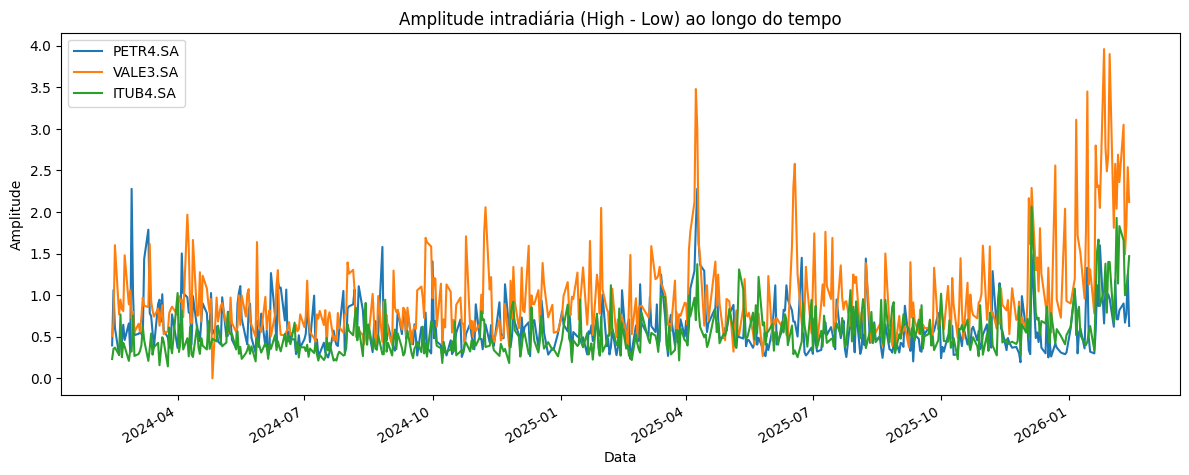

,mean,median,max,std
Ticker,,,,
VALE3.SA,0.954580,0.807872,3.959999,0.538921
PETR4.SA,0.602793,0.533814,2.280786,0.295685
ITUB4.SA,0.535110,0.456727,2.064512,0.266698


Ativo com MAIOR volatilidade (maior média de amplitude): VALE3.SA


In [3]:
# Garantir que Date existe e está em datetime
if "Date" in dados.columns:
    dados["Date"] = pd.to_datetime(dados["Date"])
else:
    # se Date estiver no índice, traz para coluna
    dados = dados.reset_index()
    dados["Date"] = pd.to_datetime(dados["Date"])

# CASO 1) Colunas MultiIndex (wide)

if isinstance(dados.columns, pd.MultiIndex):

    # High/Low podem estar no nível 0 ou 1 do MultiIndex
    if "High" in dados.columns.get_level_values(0) and "Low" in dados.columns.get_level_values(0):
        high = dados["High"].copy()
        low  = dados["Low"].copy()
    elif "High" in dados.columns.get_level_values(1) and "Low" in dados.columns.get_level_values(1):
        high = dados.xs("High", level=1, axis=1).copy()
        low  = dados.xs("Low",  level=1, axis=1).copy()
    else:
        raise ValueError("Não encontrei 'High' e 'Low' nas colunas MultiIndex.")

    # Usar Date como índice do cálculo
    high.index = dados["Date"]
    low.index  = dados["Date"]

    amp = high - low

    # Elimina duplicidade de data
    amp = amp.groupby(level=0).mean().sort_index()

    # Gráfico com eixo temporal real (datas)
    plt.figure(figsize=(12, 5))
    plt.plot(amp.index, amp.values)
    plt.title("Amplitude intradiária (High - Low) ao longo do tempo")
    plt.xlabel("Data")
    plt.ylabel("Amplitude")
    plt.legend(amp.columns)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()

    # Resumo para comparar volatilidade (média da amplitude)
    resumo = amp.agg(["mean", "median", "max", "std"]).T.sort_values("mean", ascending=False)

    display(resumo.head())
    print(f"Ativo com MAIOR volatilidade (maior média de amplitude): {resumo.index[0]}")

# CASO 2) Dados em formato "long" (com Ticker)

else:
    # garantir tipo numérico
    for col in ["High", "Low"]:
        dados[col] = pd.to_numeric(dados[col], errors="coerce")

    dados["Amplitude"] = dados["High"] - dados["Low"]

    serie_amp = (
        dados.pivot_table(index="Date", columns="Ticker", values="Amplitude", aggfunc="mean")
        .sort_index()
    )

    plt.figure(figsize=(12, 5))
    plt.plot(serie_amp.index, serie_amp.values)
    plt.title("Amplitude intradiária (High - Low) ao longo do tempo")
    plt.xlabel("Data")
    plt.ylabel("Amplitude")
    plt.legend(serie_amp.columns)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()

    resumo = (
        dados.groupby("Ticker")["Amplitude"]
        .agg(["mean", "median", "max", "std"])
        .sort_values("mean", ascending=False)
    )

    display(resumo.head())
    print(f"Ativo com MAIOR volatilidade (maior média de amplitude): {resumo.index[0]}")
    
